사전준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np

pathTrain="C:\\Users\\82109\\Desktop\\train" #학습할 이미지 
pathTest="C:\\Users\\82109\\Desktop\\test" #벨리데이션 테스트 이미지
pathGeneratorTest="C:\\Users\\82109\\Desktop\\generatorTest" #생성 테스트용 이미지
pathSave="C:\\Users\\82109\\Desktop\\checkPoint" #모델 저장할 위치
batchSize=1

In [335]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')

In [16]:
image = Image.new("RGBA", (300, 300),color=(255,0,0,255))
canvas = Image.new('RGBA', (400,400), color=(0,255,0,255))
mask=Image.new('RGBA', (300,300), color=(0,0,0,127))
canvas.paste(image,(0,0),mask=mask)

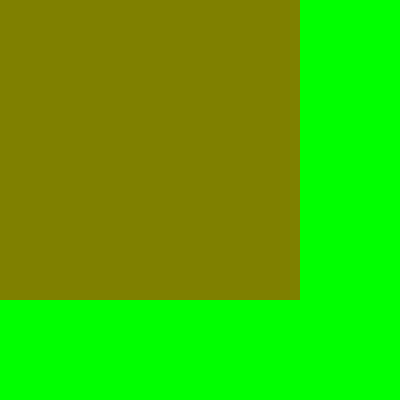

In [14]:
canvas

이미지 전처리

In [459]:
#해당 디렉토리의 모든 파일명을 가져옴

#경로 반환
def GetFilePath(path,end=".gif"):
  gifFileList=os.listdir(path)
  gifPath=[]
  for name in gifFileList:
    if name.endswith(tuple(end)):
      gifPath.append(os.path.join(path,name))
  return gifPath


#못쓰는 데이터를 걸러줌
def PreprocessGif(path,frame=5):
  gif=Image.open(path)
  size=gif.n_frames
  gif.close()
  if size<frame:
    print(path,": ",size,"사용불가능")
    os.remove(path=path)
  else:
    print(path,": ",size," 사용가능")

#gif를 읽고 넘파이 배열로 노멀라이즈해줌
def LoadGif(path, paddingSize=32):
  gif=Image.open(path)
  flip=np.random.randint(0,7)
  print("이미지 총프레임 ",gif.n_frames)
  extractFrame=np.random.randint(2,11)
  remainFrame=gif.n_frames-extractFrame
  start=0
  end=0

  if remainFrame<=1:
    start=1
    end=gif.n_frames
  else:
    start=np.random.randint(1,remainFrame+1)
    end=start+extractFrame
  print("추출 설정(추출프레임, 가용프레임, 시작, 끝) ",extractFrame,remainFrame,start,end)
  images=[]
  for i in range(start,end):
    gif.seek(i)
    temp=gif.transpose(flip).convert("RGBA")
    temp=np.array(temp)
    height=(paddingSize-temp.shape[0]%paddingSize)%paddingSize
    width=(paddingSize-temp.shape[1]%paddingSize)%paddingSize
    temp=np.pad(temp, pad_width=((0,height),(0,width),(0,0)),mode="constant",constant_values=0)
    images.append(temp)
  gif.close()

  return np.array(images)/255.0

#인풋데이터와 아웃풋 데이터를 분리
def Divide(arr):
  evens=arr[0::2]
  odds=arr[1::2]
  if evens.shape[0] != odds.shape[0]:
    evens=evens[0:-1]
  return [evens,odds]

def saveGif(path, images):
  imgs=[]
  for i in images:
    img=Image.fromarray((i*255).round().astype(np.int8), mode="RGBA")
    imgs.append(img)
  imgs[0].save(path, save_all=True, append_images=imgs[1:], disposal = 2,duration=150, loop=0)
  
#데이터셋 제너레이터 생성
def DatasetGenerater(gifPath):
  #gif파일을 반환
  for i in gifPath:
      x1,y= Divide(LoadGif(i))  
      x2=np.random.rand(x1.shape[0],x1.shape[1],x1.shape[2],x1.shape[3])
      yield (x1,x2,y)


#사용예제 

# gifPath=GetFilePath(path) 
# for i in gifPath:
#   PreprocessGif(i)

# arr=LoadGif(gifPath[3])
# input, output=Divide(arr)
# print(arr.shape ,input.shape, output.shape)





In [424]:
print("트레인셋 전처리")
#사용불가능 파일 전처리
gifPath=GetFilePath(pathTrain) 
for i in gifPath:
  PreprocessGif(i)
gifPath=GetFilePath(pathTrain)

print("테스트셋 전처리")
gifPathTest=GetFilePath(pathTest) 
for i in gifPathTest:
  PreprocessGif(i)
gifPathTest=GetFilePath(pathTest)


trainDataset=tf.data.Dataset.from_generator(DatasetGenerater,
                               args=[gifPath], output_types=(tf.float32,tf.float32,tf.float32),
                               output_shapes = ((None, None,None,4),(None, None,None,4),(None, None,None,4)))
#(inputImages, outputImages)
trainDataset=trainDataset.shuffle(10).batch(batchSize).prefetch(tf.data.experimental.AUTOTUNE)


testDataset=tf.data.Dataset.from_generator(DatasetGenerater,
                               args=[gifPathTest], output_types=(tf.float32,tf.float32,tf.float32),
                               output_shapes = ((None, None,None,4),(None, None,None,4),(None, None,None,4)))
#(inputImages, outputImages)
testDataset=testDataset.shuffle(10).batch(batchSize).prefetch(tf.data.experimental.AUTOTUNE)


트레인셋 전처리
C:\Users\82109\Desktop\datasets\1.gif :  32  사용가능
C:\Users\82109\Desktop\datasets\2.gif :  31  사용가능
C:\Users\82109\Desktop\datasets\3.gif :  128  사용가능
C:\Users\82109\Desktop\datasets\smoke_loop_animation_by_alexredfish_d8uuq6h.gif :  45  사용가능
C:\Users\82109\Desktop\datasets\tomoe_kickslash_riser_animation_by_hybridmink_d9yq8fu.gif :  15  사용가능
C:\Users\82109\Desktop\datasets\train_by_kirokaze_d9q4jxs.gif :  29  사용가능
C:\Users\82109\Desktop\datasets\t_crouch_kicks_by_hybridmink_d952wjw.gif :  13  사용가능
테스트셋 전처리
C:\Users\82109\Desktop\datasetsval\0.gif :  8  사용가능
C:\Users\82109\Desktop\datasetsval\1.gif :  32  사용가능
C:\Users\82109\Desktop\datasetsval\2.gif :  31  사용가능
C:\Users\82109\Desktop\datasetsval\train_by_kirokaze_d9q4jxs.gif :  29  사용가능


In [458]:
x,_,_=DatasetGenerater(GetFilePath(pathGeneratorTest)).__next__()
saveGif(os.path.join(pathSave,"epoch.gif"),x)

이미지 총프레임  20
추출 설정(추출프레임, 가용프레임, 시작, 끝)  3 17 1 4


unet 모델 생성

In [12]:

def seperableConv(filter, input):
    depthwise=tf.keras.layers.Conv3D(input.shape[-1],3,padding="same",groups=input.shape[-1])(input)
    pointwise=tf.keras.layers.Conv3D(filter,1,padding="same")(depthwise)
    return pointwise
    
def block(filter,input):
    #conv1=tf.keras.layers.Conv3D(filter,3,padding="same")(input)
    conv1=seperableConv(filter,input)
    layerNorm1=tf.keras.layers.LayerNormalization()(conv1)
    swishAct1=tf.keras.layers.Activation("swish")(layerNorm1)

    #conv2=tf.keras.layers.Conv3D(filter,3,padding="same")(swishAct1)
    conv2=seperableConv(filter,swishAct1)
    layerNorm2=tf.keras.layers.LayerNormalization()(conv2)
    swishAct2=tf.keras.layers.Activation("swish")(layerNorm2)
    
    return swishAct2


def unetModel(inputShape=(None, None, None, 4)):
    
    inputImage=tf.keras.Input(shape=inputShape)
    noisyImage=tf.keras.Input(shape=inputShape)
    input=tf.keras.layers.Concatenate()([inputImage,noisyImage])
    
    #인코딩
    e1=block(32,input)
    e1Pooling=tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(e1)
    
    e2=block(64,e1Pooling)
    e2Pooling=tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(e2)
    
    e3=block(128,e2Pooling)
    e3Pooling=tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(e3)
    
    e4=block(256,e3Pooling)
    e4Pooling=tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(e4)
    
    e5=block(512,e4Pooling)
    e5Pooling=tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(e5)
    
    #중간
    bottleNeck=block(1024,e5Pooling)

    d5UpSampling=tf.keras.layers.UpSampling3D(size=(1,2,2))(bottleNeck)
    d5Transpose=seperableConv(512,d5UpSampling)
    d5Concatenate=tf.keras.layers.Concatenate()([d5Transpose,e5])
    d5=block(512,d5Concatenate)
    
    d4UpSampling=tf.keras.layers.UpSampling3D(size=(1,2,2))(d5)
    d4Transpose=seperableConv(256,d4UpSampling)
    d4Concatenate=tf.keras.layers.Concatenate()([d4Transpose,e4])
    d4=block(256,d4Concatenate)
    
    d3UpSampling=tf.keras.layers.UpSampling3D(size=(1,2,2))(d4)
    d3Transpose=seperableConv(128,d3UpSampling)
    d3Concatenate=tf.keras.layers.Concatenate()([d3Transpose,e3])
    d3=block(128,d3Concatenate)
    
    d2UpSampling=tf.keras.layers.UpSampling3D(size=(1,2,2))(d3)
    d2Transpose=seperableConv(64,d2UpSampling)
    d2Concatenate=tf.keras.layers.Concatenate()([d2Transpose,e2])
    d2=block(64,d2Concatenate)
    
    d1UpSampling=tf.keras.layers.UpSampling3D(size=(1,2,2))(d2)
    d1Transpose=seperableConv(32,d1UpSampling)
    d1Concatenate=tf.keras.layers.Concatenate()([d1Transpose,e1])
    d1=block(32,d1Concatenate)
    
    outputImage=seperableConv(4,d1)
    
    return tf.keras.Model([inputImage,noisyImage],outputImage)


디퓨전

In [18]:
class DiffusionModel(tf.keras.Model):
    def __init__(self,network:tf.keras.Model,batchSize=1):
        super().__init__()
        self.network= network
        self.batchSize=batchSize
    
    def train_step(self, images):

        inputImages, noises, outputImages=images
        #학습할 노이즈 생성
        
        diffusionTime = tf.random.uniform(
            shape=(1,1, 1, 1, 1), minval=0.0, maxval=1.0
        )
        sigRates, noiseRates= self.diffusionSchedule(diffusionTime)
        noisyImage = sigRates * outputImages + noiseRates * noises
        
        with tf.GradientTape() as tape:
            predinputImages=self.network([inputImages,noisyImage],training=True)
            loss=self.compiled_loss(noises,predinputImages)

        gradients = tape.gradient(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, images):
        inputImages, noises, outputImages=images
        
        diffusionTime = tf.random.uniform(
            shape=(1,1, 1, 1, 1), minval=0.0, maxval=1.0
        )
        sigRates, noiseRates= self.DiffusionSchedule(diffusionTime)
        noisyImage = sigRates * outputImages + noiseRates * noises
 
        predinputImages=self.network([inputImages,noisyImage],training=False)
        loss=self.compiled_loss(noises,predinputImages)
        
        return {m.name: m.result() for m in self.metrics}
    
    def DiffusionSchedule(self, diffusionTime):
        #각도가 줄어들음 (y축이 노이즈, x축이 시그널)
        startAng=tf.acos(0.99) #  라디안 단위(180/파이), 약 0, 시그널 최대
        endAng=tf.acos(0.01) # 약 90도, 노이즈 최대
        
        diffusionAng=startAng+diffusionTime*(endAng-startAng) #DFT가 1에 가까울수록 노이즈(1에서 시작)
        sigRate=tf.cos(diffusionAng) # DFT가 1에 가까울수록 0.01
        noiseRate=tf.sin(diffusionAng) # DFT가 1에 가까울수록 0.99
        return sigRate, noiseRate
        
    def Generator(self,inputImage:np.ndarray,diffusionStep):
        stepSize=1.0 / diffusionStep

        for step in range(diffusionStep):
            pass
        
        
        noises=np.random.rand(
            1,
            self.generatorTestImage.shape[0],
            self.generatorTestImage.shape[1],
            self.generatorTestImage.shape[2],
            self.generatorTestImage.shape[3]
        )
        for step in range(self.diffusionStep):
            self.network([self.generatorTestImage,noises])
            
    
    def GeneratorTest(self, epoch=None, logs=None):
        if self.generatorTestImage==None:
            return
            
            
        
#network([np.random.rand(1,4,64,64,4),np.random.rand(1,4,64,64,4)],training=False)

In [ ]:
#모델생성
network=unetModel(inputShape=(None,None,None,4))
model=DiffusionModel(network)

#콜백생성
cpCallback = tf.keras.callbacks.ModelCheckpoint(
    filepath=pathSave, 
    verbose=1, 
    save_weights_only=True)
esCallback=tf.keras.callbacks.EarlyStopping(patience=5)
rlrCallback=tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=3,
    min_lr=1e-5)

#컴파일
model.compile(
    tf.keras.optimizers.experimental.AdamW(
        learning_rate=1e-2, weight_decay=1e-4
    ),
    loss=tf.keras.losses.mean_squared_error,
              metrics=['accuracy'])



In [ ]:
model.fit(
    trainDataset,
    epochs=100,
    batch_size=1,
    validation_data=testDataset,
    validation_batch_size=1,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.GeneratorTest),
        ,cpCallback,
        esCallback,
        rlrCallback
    ]
)

스낵코드

model.evalu

diffusionTime = tf.random.uniform(
            shape=(1,10, 1024, 1024, 1), minval=10, maxval=20
)
diffusionTime2 = tf.random.uniform(
    shape=(1,10,1024,1024, 4), minval=0.0, maxval=1.0
)

savePath="C:\Users\82109\Desktop\checkPoint\test.ckpt"

model=unetModel(inputShape=(None,None,None,4)) model.save_weights(filepath=savePath)

model=unetModel(inputShape=(None,None,None,4)) model.load_weights(filepath=savePath)

model=unetModel(inputShape=(None,None,None,4)) model.load_weights(filepath=savePath)

unetModel().summary()